# 1 CLIP zero-shot prediction

### Basic Imports

In [2]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

import seaborn as sns
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [3]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONE = 'ViT-B/16' # RN50, ViT-B/32, ViT-B/16


### Device

In [4]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# 定义FashionMNIST测试数据集的转换
transform_fashionmnist_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.2869618660379201,), (0.3037346706584096,)),  # FashionMNIST的均值和标准差
])

# 加载FashionMNIST测试数据集
test_set = datasets.FashionMNIST(root='./data', train=False,
                                               download=True, transform=transform_fashionmnist_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                                             shuffle=False, num_workers=2)

# FashionMNIST的类别名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # 替换为FashionMNIST类别标签
dataset_name = 'FashionMNIST'  # 修改数据集名称

In [5]:
all_means = []
all_stds = []

for i in range(len(test_set)):
    sample = test_set[i]
    all_means.append(sample[0].mean().item())
    all_stds.append(sample[0].std().item())

# 计算整个测试集的均值和标准差
total_mean = sum(all_means) / len(all_means)
total_std = sum(all_stds) / len(all_stds)

print(total_mean)
print(total_std)

1.0380220919614658e-08
1.0000000315025448


### Model

In [6]:
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [7]:
prompt = 'a photo of a'

def prompt_encode(prompt):
    """
    Args:
        prompt (str): the text prefix before the class

    Returns:
        text_inputs(torch.Tensor)

    """
    
    # 使用CLIP模型编码提示
    text_inputs = torch.cat([clip.tokenize(f"{prompt}{c}") for c in class_names]).to(device)
    
    return text_inputs


In [8]:
def model_inference(model, image, text_inputs):

    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)
    
    image_features /= image_features.norm(dim = -1, keepdim = True)
    text_features /= text_features.norm(dim = -1, keepdim = True)
    
    logit_scale = model.logit_scale.exp()
    
    logits = logit_scale * image_features @ text_features.t()
    
    return logits

In [9]:
def visualize_samples(images, text_inputs, preds, targets, class_names):
    """
    Visualize some samples including input images, predicted labels, and true labels.

    Args:
        images (Tensor): Input images.
        text_inputs (Tensor): Text inputs.
        preds (Tensor): Predicted labels.
        targets (Tensor): True labels.
        class_names (list): List of class names.
    """
    num_samples = min(2, len(images))  # Visualize up to 2 samples

    fig, axs = plt.subplots(1, num_samples, figsize=(12, 3))

    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}\n{text_inputs[i]}')

    plt.show()

In [10]:
def plot_results(loss_values, acc_values):
    """
    Plot training or testing results, including loss and accuracy trends.

    Args:
        loss_values (list): List of loss values.
        acc_values (list): List of accuracy values.
    """

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, 'bo-', label='Testing Loss')
    plt.title('Testing Loss')
    plt.xlabel('')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc_values, 'ro-', label='Testing Accuracy')
    plt.title('Testing Accuracy')
    plt.xlabel('')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


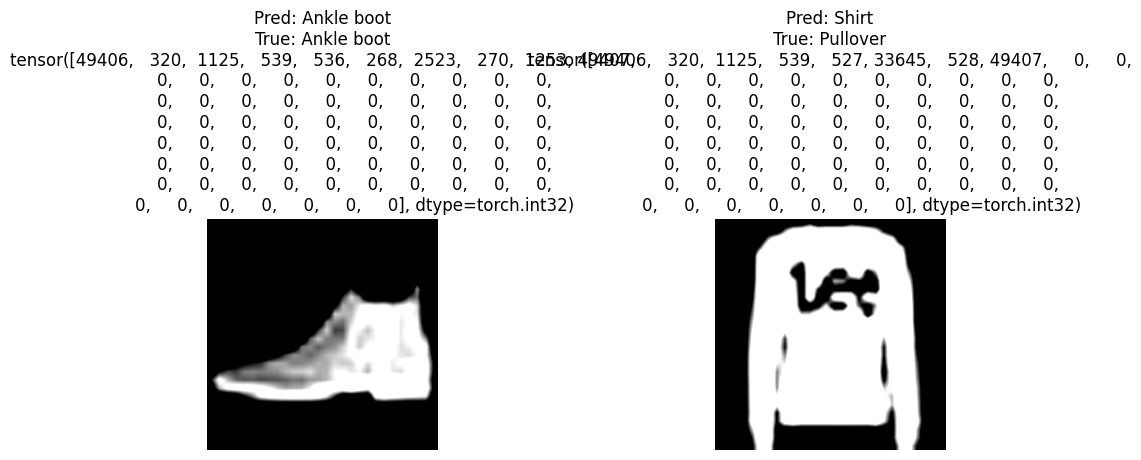

Average testing loss on FashionMNIST: 2.3625
the zero-shot performance on FashionMNIST is 27.88%, visual encoder is ViT-B/16.


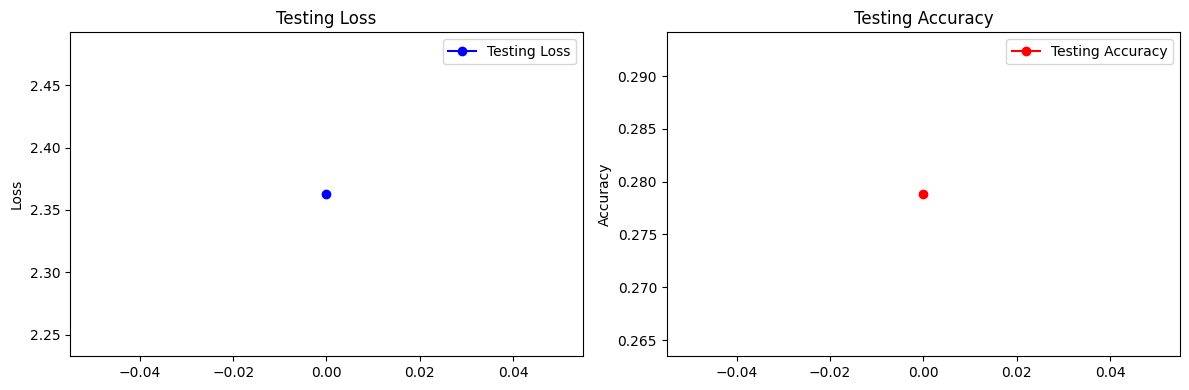

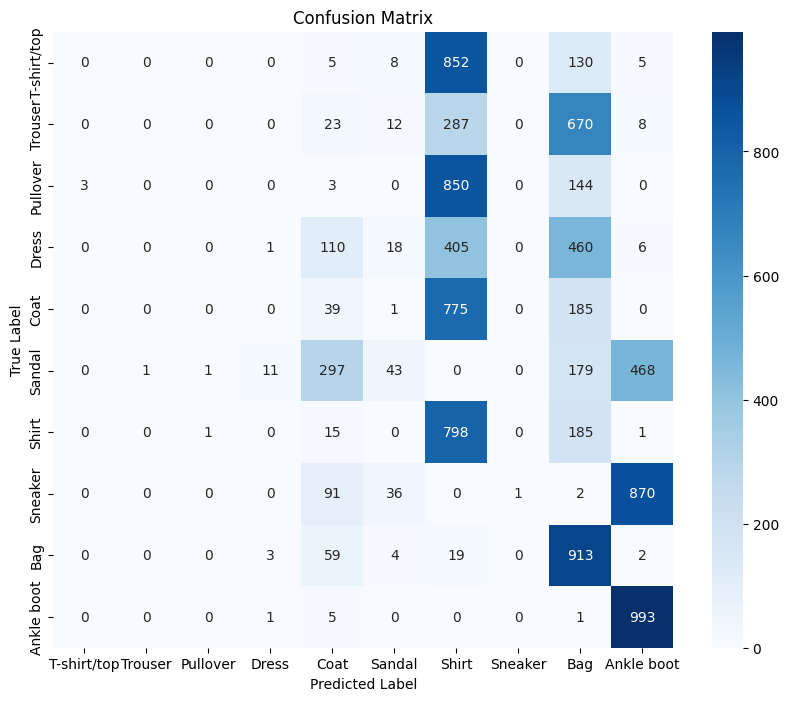

In [11]:
testing_loss = []
testing_acc = []
criterion = nn.CrossEntropyLoss()
predictions = []

with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0
    
    for batch_idx, (image, target) in enumerate(test_dataloader):
        image = image.to(device)
        target = target.to(device)
        text_inputs = prompt_encode(prompt)
        #test model
        logits = model_inference(model, image, text_inputs)
        loss = criterion(logits, target)
        
        val_loss += loss.item()
        
        _, preds = torch.max(logits, 1)
        val_corrects += torch.sum(preds == target.data)
        
        predictions.extend(preds.cpu().numpy())
        
        # Additional: Visualize some samples
        if batch_idx == 0:  # Visualize only for the first batch
            visualize_samples(image, text_inputs, preds, target, class_names)  # 实现此函数来可视化样本
        
    avg_loss = val_loss / len(test_dataloader)    
    val_acc = val_corrects.double() / len(test_set)
    
    print(f"Average testing loss on {dataset_name}: {avg_loss:.4f}")
    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
    testing_loss.append(avg_loss)
    testing_acc.append(val_acc)
# Additional: Visualize overall performance (loss and accuracy)
plot_results(testing_loss, testing_acc)  # 实现此函数来绘制图表
# Additional: Confusion Matrix
conf_matrix = confusion_matrix(test_set.targets.cpu().numpy(), np.array(predictions))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



现在使用DenseNet-121作为基线模型：

In [7]:
from torchvision.models import densenet121  # 选择适当的 DenseNet 模型
import torch.nn.functional as F

In [13]:
densenet_model = densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
densenet_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
# 获取原始的全连接层
original_classifier = densenet_model.classifier

# 获取原始全连接层的输入维度
in_features = original_classifier.in_features

# 修改最后一层的输出维度（假设你有 10 个类别）
densenet_model.classifier = nn.Linear(in_features, 10)  # 修改 10 为你的实际类别数量

In [16]:
# 修改图像预处理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # 删除CenterCrop，因为DenseNet对输入大小有要求
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载FashionMNIST测试数据集
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=preprocess)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    output = model(image)
    num_classes = 10
    loss = criterion(output,target)
    
    return output, loss

In [19]:
def DN_visualize_samples(images, dense_preds, targets, class_names):
    """
    Visualize some samples including input images, predicted labels, and true labels.

    Args:
        images (Tensor): Input images.
        text_inputs (Tensor): Text inputs.
        preds (Tensor): Predicted labels.
        targets (Tensor): True labels.
        class_names (list): List of class names.
    """
    num_samples = min(4, len(images))  # Visualize up to 4 samples

    fig, axs = plt.subplots(1, num_samples, figsize=(12, 3))

    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        axs[i].imshow(image)
        axs[i].axis('off')
    
        axs[i].set_title(f'Pred: {class_names[dense_preds[i]]}\nTrue: {class_names[targets[i]]}')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


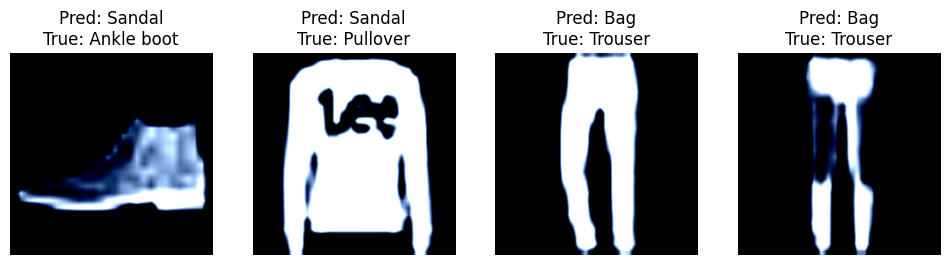

Average testing loss on FashionMNIST: 2.3809
Average testing acc on FashionMNIST is 10.07%.


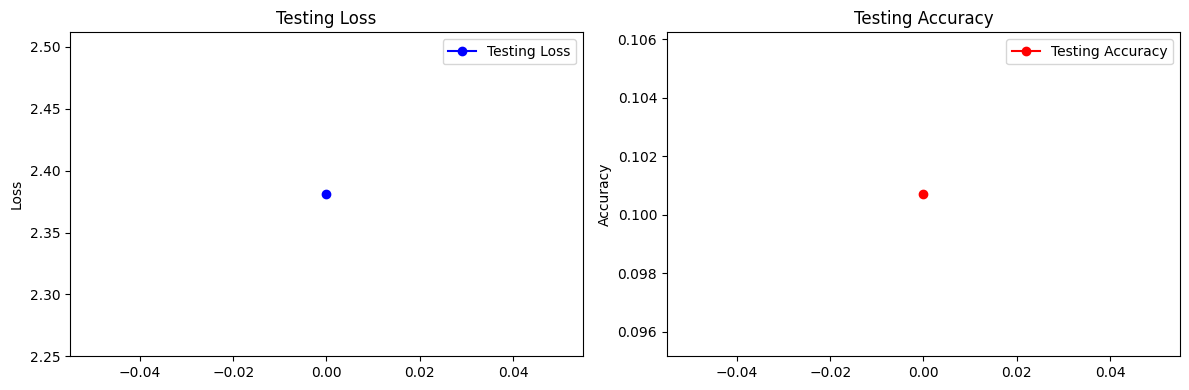

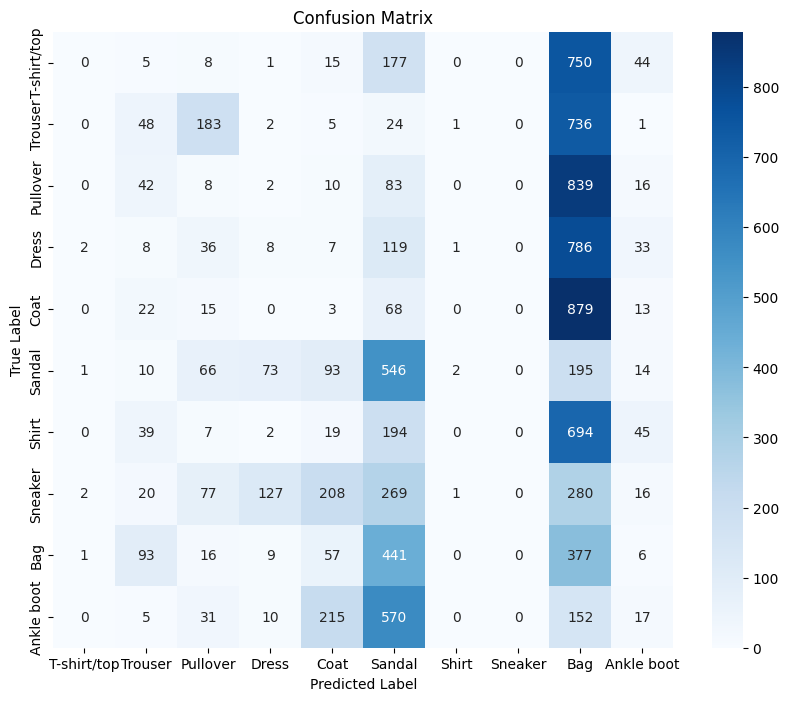

In [ ]:
testing_loss = []
testing_acc = []
predictions = []

with torch.no_grad():
    densenet_model.eval()

    val_loss = 0.0
    val_corrects = 0
    
    for batch_idx, (image, target) in enumerate(test_dataloader):
        image = image.to(device)
        target = target.to(device)
        
        outputs, loss = test_batch(densenet_model, image, target)
        _, dense_preds = torch.max(outputs, 1)
            
        val_loss += loss.item()
        val_corrects += torch.sum(dense_preds == target.data)
        
        predictions.extend(dense_preds.cpu().numpy())
        
        # Additional: Visualize some samples
        if batch_idx == 0:  # Visualize only for the first batch
            DN_visualize_samples(image, dense_preds, target, class_names)  # 实现此函数来可视化样本
        
    avg_loss = val_loss / len(test_dataloader)    
    val_acc = val_corrects.double() / len(test_set)
    
    print(f"Average testing loss on {dataset_name}: {avg_loss:.4f}")
    print(f"Average testing acc on {dataset_name} is {val_acc*100:.2f}%.")
    testing_loss.append(avg_loss)
    testing_acc.append(val_acc)
# Additional: Visualize overall performance (loss and accuracy)
plot_results(testing_loss, testing_acc)  # 实现此函数来绘制图表
# Additional: Confusion Matrix
conf_matrix_DN = confusion_matrix(test_set.targets.cpu().numpy(), np.array(predictions))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_DN, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

现在我们尝试对DenseNet-121模型进行训练后再测试

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
# 修改图像预处理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # 删除CenterCrop，因为DenseNet对输入大小有要求
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载FashionMNIST训练数据集
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=preprocess)
trainloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 加载FashionMNIST测试数据集
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#取前面1/5作为验证集
validationloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(range(len(trainset)//5)))

In [20]:
# 定义 DenseNet-121 模型
model = densenet121(pretrained=False)
model.to(device)
# 获取原始的全连接层
original_classifier = model.classifier

# 获取原始全连接层的输入维度
in_features = original_classifier.in_features

# 修改最后一层的输出维度（假设你有 10 个类别）
model.classifier = nn.Linear(in_features, 10)  # 修改 10 为你的实际类别数量

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# 训练模型
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 在验证集上计算准确率
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in validationloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# 在测试集上计算准确率
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/5, Loss: 0.7196, Accuracy: 0.6742
Epoch 2/5, Loss: 0.4231, Accuracy: 0.7637
Epoch 3/5, Loss: 0.1918, Accuracy: 0.8207
Epoch 4/5, Loss: 0.1688, Accuracy: 0.5903
Epoch 5/5, Loss: 0.0479, Accuracy: 0.7194
Test Accuracy: 0.7254
